# ARL Compare


In [3]:
from exp import *


In [4]:
# pip install --upgrade efficientnet-pytorch


## Load the dataset

In [5]:
dm = DatasetManager('2017',224,'all','2017')

In [6]:
def reload_dataset(dm,segmented=False, seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.3, max_lighting=0.0,p_affine=1, max_warp=0)
    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name + ('_segmented' if segmented else ''),
                   valid=dm.get_dataset_path('valid_images').name +('_segmented' if segmented else ''))\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=224)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm)

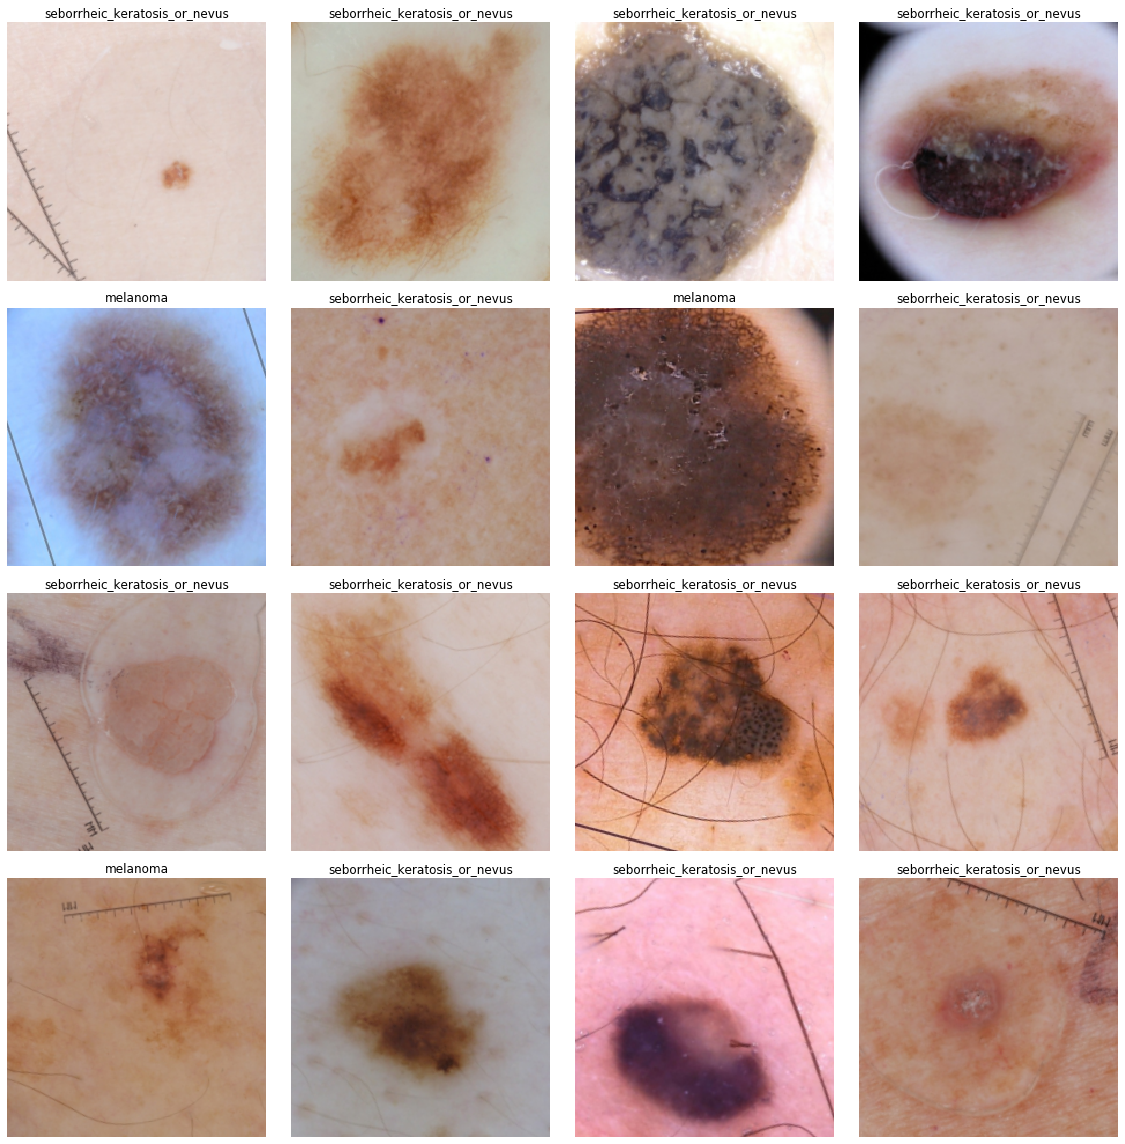

In [89]:
data.show_batch()

In [5]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 seborrheic_keratosis_or_nevus    1626
melanoma                          374
dtype: int64 

 valid_count: 
 seborrheic_keratosis_or_nevus    120
melanoma                          30
dtype: int64
ratios:
seborrheic_keratosis_or_nevus    0.073801
melanoma                         0.080214
dtype: float64 %


# Adding attention

In [7]:
from torchvision.models.resnet import Bottleneck
import types

In [8]:
alpha_initial_value = 0.0001
def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

            
        #identity N x C x H x W
        #alpha C
        #out N x C x H x W
        #out * identity * alpha = N x C x H x W
        
        
        out = out + (identity 
                     * self.softmaxLayer(out.view(*out.size()[:2], -1)).view_as(out) 
                     * self.alpha) + (identity)

        out = self.relu(out)
        return out

def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( forward,a_module)
    
def add_attn_params(a_module):
    #apply softmax on the third dimension (indexed by 2 since we count from 0)
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
#     print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [9]:
ResNet50_with_attn = models.resnet50(pretrained=True)
apply_leaf(ResNet50_with_attn, change_basic_blocks)

In [10]:
bottlenecks = [bn for bn in ResNet50_with_attn.modules() if isinstance(bn,Bottleneck)]

class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [11]:
for b in bottlenecks:
    assert b.alpha.requires_grad

## Create the learners

In [14]:
learn_baseline = cnn_learner(data, models.resnet50, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph, partial(Alphas, modules=bottlenecks),OverSamplingCallback ], pretrained=True)

In [16]:
len(learn_baseline.data.train_dl)

125

In [28]:
learn_baseline.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [16]:
seed = 1 
random_seed(seed,True)
learn_attn = cnn_learner(data, lambda x: ResNet50_with_attn, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph, partial(Alphas, modules=bottlenecks), OverSamplingCallback], pretrained=True)

RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 10.91 GiB total capacity; 1.66 GiB already allocated; 17.06 MiB free; 1.72 GiB reserved in total by PyTorch)

In [13]:
len(learn_attn.data.train_dl)

125

In [14]:
ps = list(learn_attn.model.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

assert len(ls) == 16

# ps = list(learn_baseline.model.named_parameters())

# ls = [n for n in ps if 'alpha' in n[0]]

# assert len(ls) == 0

# Train Learn attn and visualize alphas

In [123]:
!nvidia-smi

Mon Aug 24 12:24:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 23%   32C    P2    55W / 250W |   3605MiB / 11176MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [124]:
seed =1 
epochs=20
ResNet50_with_attn = models.resnet50(pretrained=True)
apply_leaf(ResNet50_with_attn, change_basic_blocks)
    
arl_acc = train_model_and_return_metrics(data,lambda x: ResNet50_with_attn, seed,epochs)

NameError: name 'train_model_and_return_metrics' is not defined

In [21]:
#con oversampling bs = 16
random_seed(seed,True)
learn_attn.fit_one_cycle(20,max_lr=slice(3e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


RuntimeError: Could not infer dtype of NoneType

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.885923,0.515632,0.240000,0.760000,0.732222,00:21
1,0.629300,0.433604,0.200000,0.800000,0.819167,00:21
2,0.524906,0.432382,0.193333,0.806667,0.775833,00:21
3,0.505263,0.403700,0.166667,0.833333,0.800833,00:21


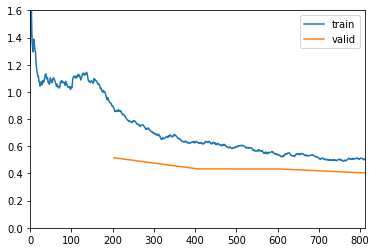

In [14]:
#con oversampling
random_seed(seed,True)
learn_attn.fit_one_cycle(4,max_lr=slice(3e-3))

In [15]:
#con oversampling bs = 16
learn_attn.unfreeze()
learn_attn.fit_one_cycle(20,max_lr=slice(3e-4))


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


RuntimeError: number of dims don't match in permute

In [1]:
a_file = open("results/alphas.txt", "w")
for row in learn_attn.alphas.stats[0]:
    np.savetxt(a_file, row)

a_file.close()

NameError: name 'learn_attn' is not defined

In [54]:
learn_attn.alphas.stats[0].shape

torch.Size([2, 16, 101])

In [2]:
original_array = np.loadtxt("results/alphas.txt").reshape(16, 4060)


NameError: name 'np' is not defined

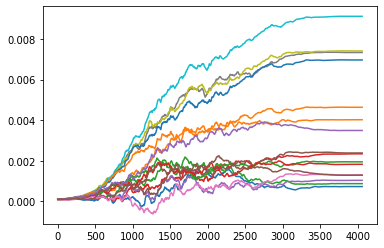

In [28]:
for i in range(len(original_array)):
    plt.plot(original_array[i])

In [46]:
learn_attn.data.train_ds

LabelList (2000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
seborrheic_keratosis_or_nevus,melanoma,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus,seborrheic_keratosis_or_nevus
Path: .

In [60]:
np.linspace(0,20,21)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])

In [42]:
batches_per_epoch_with_oversampling = 203

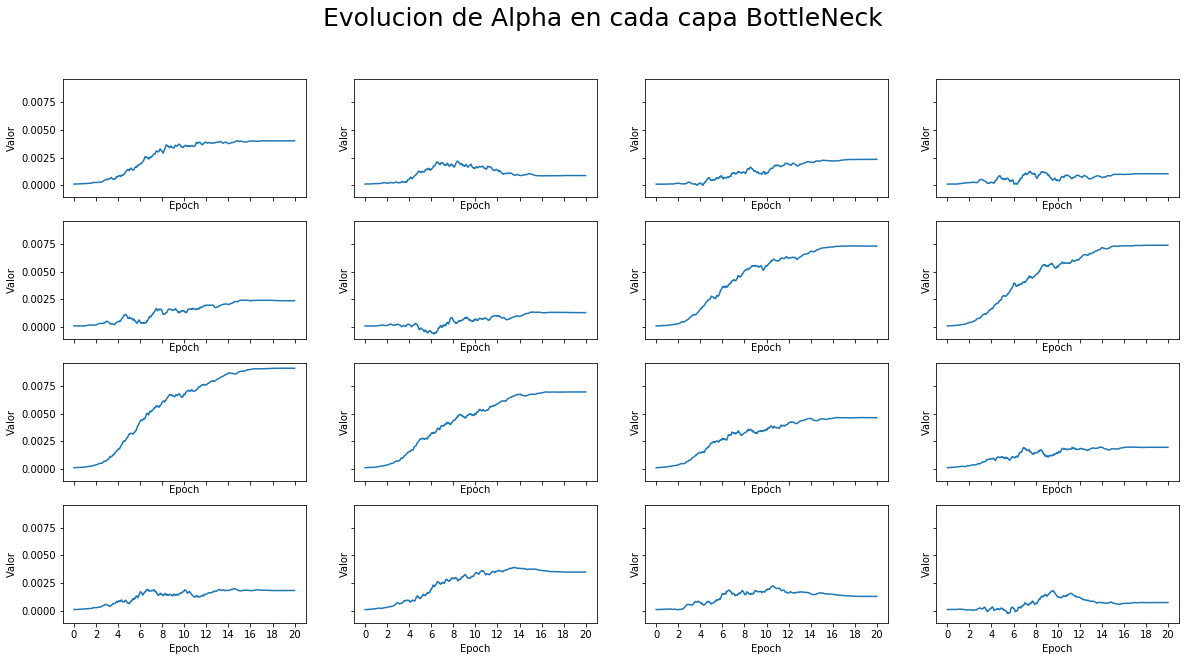

In [82]:
fig,axs = plt.subplots(4,4, figsize=(20,10), sharey=True, sharex=True)
fig.suptitle('Evolucion de Alpha en cada capa BottleNeck', fontsize=25)
batches_per_epoch_with_oversampling = 203 #bs=16
epochs = 20 
for i in range(len(original_array)):
    ax = axs[(i-1) // 4, (i-1) % 4]    
    ax.plot(original_array[i])
    forward_passes = original_array[i];
    x_ticks_positions = [batches_per_epoch_with_oversampling * i for i in range(len(forward_passes))][:epochs+1][0::2]
    x_ticks_labels = list(range(epochs+1))[0::2]
    ax.set_xticks(x_ticks_positions) 
    ax.set_xticklabels(x_ticks_labels) 

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Valor')
    

# Training

In [11]:
def train_model_and_return_metrics(data,model,seed,epochs):
    random_seed(seed,True)
    learner = cnn_learner(data, model, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph, OverSamplingCallback], 
                        pretrained=True)
    
        
    random_seed(seed,True)
    learner.fit_one_cycle(4,max_lr=slice(3e-3))
    accuracies = list(map(lambda x: x[1], learner.recorder.metrics))
    aurocs = list(map(lambda x: x[2], learner.recorder.metrics))

    #Unfreeze
    learner.unfreeze()
    learner.fit_one_cycle(epochs, max_lr=slice(3e-4))
    
    accuracies += list(map(lambda x: x[1], learner.recorder.metrics))
    aurocs += list(map(lambda x: x[2], learner.recorder.metrics))


    return accuracies, aurocs

# Comparison Various seeds

In [12]:
results_file_name = 'results/third_take_resnet_50_arl_seed'
columns = ['Baseline_acc','Baseline_auroc','ARL_acc','ARL_auroc']

In [13]:
def write_results(seed,*args):
    f = open(f'{results_file_name}_{seed}.txt','w+')
    f.write(','.join(columns) + '\n')
    
    for epoch in zip(*args):
        line = ''
        for idx, variant in enumerate(epoch):
            line += str(variant.item())
            if idx != (len(epoch) - 1): 
                line += ','
            else: 
                line += '\n'
        
        f.write(line)


    f.close()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.888062,0.527901,0.240000,0.760000,0.716389,00:15
1,0.620967,0.446651,0.186667,0.813333,0.791945,00:15
2,0.523513,0.465245,0.213333,0.786667,0.736667,00:15
3,0.498550,0.421866,0.180000,0.820000,0.778333,00:15


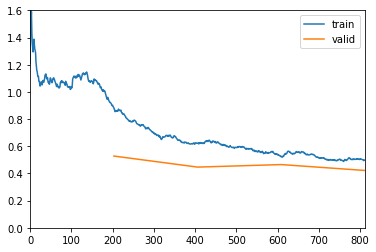

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.480813,0.422013,0.153333,0.846667,0.781111,00:23
1,0.453872,0.411341,0.153333,0.846667,0.791389,00:23
2,0.421142,0.425809,0.160000,0.840000,0.785278,00:23
3,0.383864,0.406684,0.126667,0.873333,0.825000,00:23
4,0.353065,0.386596,0.166667,0.833333,0.849167,00:23
5,0.320587,0.527226,0.166667,0.833333,0.809444,00:23
6,0.284443,0.448939,0.166667,0.833333,0.848889,00:23
7,0.242907,0.579566,0.160000,0.840000,0.841111,00:23
8,0.250610,0.428312,0.160000,0.840000,0.860833,00:23
9,0.205140,0.442674,0.126667,0.873333,0.885000,00:23


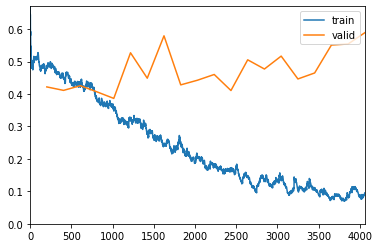

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.885923,0.515632,0.240000,0.760000,0.732222,00:22
1,0.629300,0.433604,0.200000,0.800000,0.819167,00:22
2,0.524906,0.432382,0.193333,0.806667,0.775833,00:22
3,0.505263,0.403700,0.166667,0.833333,0.800833,00:22


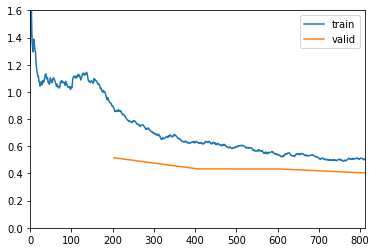

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.484629,0.414204,0.160000,0.840000,0.799445,00:30
1,0.458247,0.397007,0.153333,0.846667,0.802500,00:30
2,0.425784,0.413997,0.180000,0.820000,0.790000,00:30
3,0.390663,0.384270,0.140000,0.860000,0.836667,00:30
4,0.357220,0.429333,0.173333,0.826667,0.813889,00:30
5,0.332007,0.521471,0.180000,0.820000,0.804167,00:30
6,0.274437,0.460179,0.173333,0.826667,0.849722,00:30
7,0.266450,0.460394,0.153333,0.846667,0.852778,00:30
8,0.250181,0.390765,0.146667,0.853333,0.883056,00:30
9,0.195545,0.416238,0.113333,0.886667,0.887500,00:30


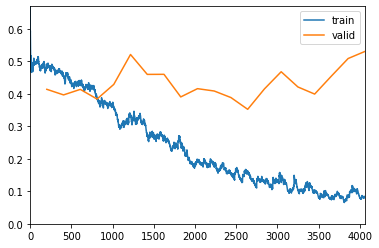

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.896906,0.719756,0.313333,0.686667,0.748611,00:16
1,0.632673,0.442610,0.153333,0.846667,0.754722,00:16
2,0.532899,0.449973,0.173333,0.826667,0.757778,00:16
3,0.517452,0.412736,0.173333,0.826667,0.775556,00:16


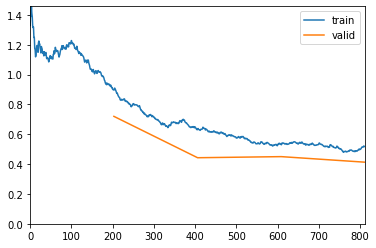

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.496947,0.422669,0.173333,0.826667,0.773611,00:23
1,0.441641,0.397344,0.146667,0.853333,0.793611,00:23
2,0.435183,0.427229,0.173333,0.826667,0.796389,00:23
3,0.414765,0.367227,0.166667,0.833333,0.853611,00:23
4,0.372497,0.406923,0.180000,0.820000,0.856111,00:23
5,0.300104,0.512310,0.160000,0.840000,0.794167,00:23
6,0.276216,0.554001,0.220000,0.780000,0.792222,00:23
7,0.286343,0.519166,0.186667,0.813333,0.855278,00:23
8,0.245704,0.566179,0.173333,0.826667,0.819167,00:23
9,0.188810,0.589840,0.186667,0.813333,0.846111,00:23


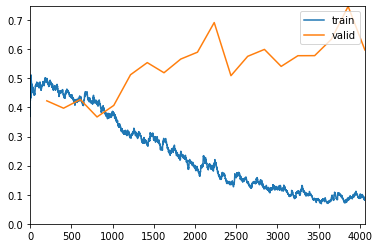

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.895931,0.768132,0.340000,0.660000,0.744722,00:22
1,0.644399,0.449037,0.173333,0.826667,0.753889,00:22
2,0.538119,0.448431,0.146667,0.853333,0.760556,00:22
3,0.512110,0.412715,0.173333,0.826667,0.778056,00:22


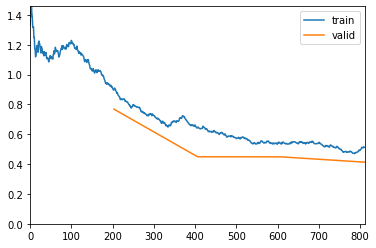

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.494164,0.424305,0.173333,0.826667,0.776667,00:30
1,0.427633,0.403395,0.153333,0.846667,0.790278,00:30
2,0.445636,0.412139,0.186667,0.813333,0.803889,00:30
3,0.424597,0.359881,0.146667,0.853333,0.860000,00:30
4,0.373946,0.407820,0.166667,0.833333,0.838055,00:30
5,0.287709,0.519152,0.186667,0.813333,0.776945,00:30
6,0.275362,0.457231,0.193333,0.806667,0.815556,00:30
7,0.278685,0.468145,0.153333,0.846667,0.851111,00:30
8,0.254644,0.593825,0.186667,0.813333,0.776111,00:30
9,0.189070,0.735792,0.180000,0.820000,0.808611,00:30


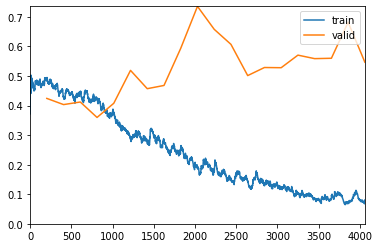

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.897121,0.669692,0.326667,0.673333,0.639167,00:16
1,0.647309,0.478543,0.226667,0.773333,0.798333,00:16
2,0.543314,0.426489,0.193333,0.806667,0.776944,00:16
3,0.494038,0.403386,0.166667,0.833333,0.781944,00:16


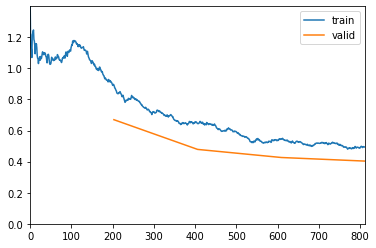

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.494668,0.409471,0.186667,0.813333,0.784722,00:23
1,0.442129,0.396994,0.166667,0.833333,0.805278,00:23
2,0.419249,0.380969,0.146667,0.853333,0.835000,00:23
3,0.351613,0.402137,0.146667,0.853333,0.852500,00:23
4,0.345697,0.424315,0.146667,0.853333,0.836111,00:23
5,0.319396,0.411654,0.173333,0.826667,0.843889,00:23
6,0.298125,0.427070,0.160000,0.840000,0.830000,00:23
7,0.238308,0.379222,0.146667,0.853333,0.885000,00:23
8,0.230878,0.422150,0.126667,0.873333,0.879167,00:23
9,0.181241,0.466987,0.133333,0.866667,0.876667,00:23


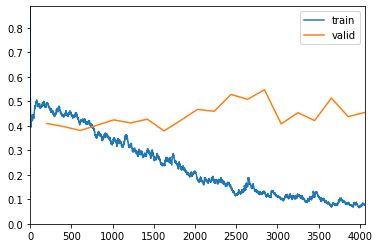

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.892561,0.694962,0.346667,0.653333,0.642222,00:22
1,0.637207,0.482383,0.220000,0.780000,0.782222,00:22
2,0.537687,0.413192,0.200000,0.800000,0.785833,00:22
3,0.491109,0.386353,0.146667,0.853333,0.808056,00:22


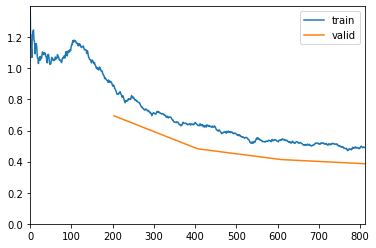

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.495359,0.394718,0.166667,0.833333,0.803889,00:30
1,0.441432,0.379740,0.160000,0.840000,0.825000,00:30
2,0.434645,0.391880,0.140000,0.860000,0.821111,00:30
3,0.358576,0.403736,0.180000,0.820000,0.844722,00:30
4,0.344734,0.403719,0.166667,0.833333,0.829444,00:30
5,0.325496,0.384807,0.173333,0.826667,0.850278,00:30
6,0.299547,0.363797,0.106667,0.893333,0.866389,00:30
7,0.237343,0.363458,0.133333,0.866667,0.879722,00:30
8,0.233975,0.455718,0.133333,0.866667,0.875000,00:30
9,0.181208,0.585215,0.166667,0.833333,0.851111,00:30


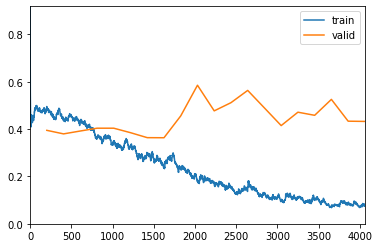

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.870725,0.592601,0.233333,0.766667,0.728611,00:16
1,0.612181,0.544438,0.206667,0.793333,0.716111,00:16
2,0.558248,0.427407,0.160000,0.840000,0.801111,00:16
3,0.480998,0.427375,0.173333,0.826667,0.781389,00:16


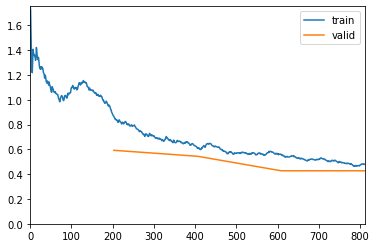

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.467514,0.419574,0.200000,0.800000,0.792500,00:23
1,0.464583,0.399867,0.160000,0.840000,0.805000,00:23
2,0.429601,0.388944,0.180000,0.820000,0.824445,00:23
3,0.383379,0.424964,0.146667,0.853333,0.828889,00:23
4,0.373498,0.393318,0.166667,0.833333,0.842222,00:23
5,0.329802,0.415180,0.173333,0.826667,0.843889,00:23
6,0.284512,0.488382,0.180000,0.820000,0.798889,00:23
7,0.246066,0.504859,0.160000,0.840000,0.820833,00:23
8,0.216999,0.402853,0.160000,0.840000,0.869167,00:23
9,0.198914,0.472593,0.140000,0.860000,0.884445,00:23


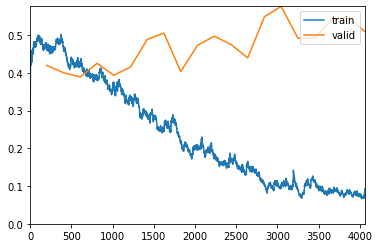

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.874909,0.572678,0.213333,0.786667,0.740556,00:22
1,0.611687,0.535776,0.206667,0.793333,0.706667,00:22
2,0.548052,0.444520,0.213333,0.786667,0.792500,00:22
3,0.485841,0.431618,0.186667,0.813333,0.773611,00:22


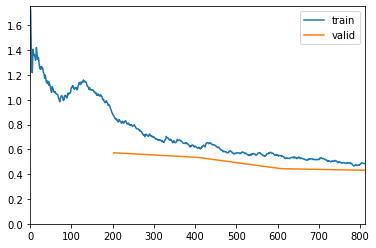

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.466978,0.426573,0.193333,0.806667,0.772500,00:30
1,0.454228,0.415970,0.173333,0.826667,0.790556,00:30
2,0.425213,0.400517,0.173333,0.826667,0.808889,00:30
3,0.379739,0.448261,0.160000,0.840000,0.830556,00:30
4,0.368118,0.364398,0.126667,0.873333,0.865556,00:30
5,0.335644,0.371549,0.160000,0.840000,0.866111,00:30
6,0.289955,0.458470,0.166667,0.833333,0.847500,00:30
7,0.247189,0.534566,0.186667,0.813333,0.814722,00:30
8,0.213224,0.413369,0.153333,0.846667,0.870556,00:30
9,0.195457,0.558182,0.180000,0.820000,0.866389,00:30


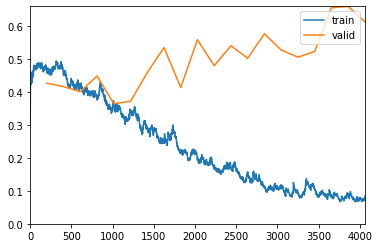

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.926511,0.600205,0.280000,0.720000,0.721667,00:16
1,0.649014,0.486948,0.193333,0.806667,0.718056,00:16
2,0.531513,0.470853,0.253333,0.746667,0.753889,00:16
3,0.478521,0.431973,0.206667,0.793333,0.774722,00:16


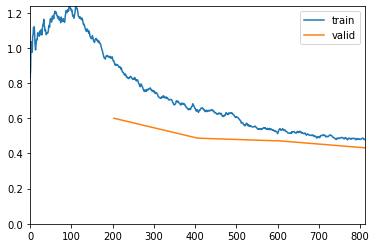

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.474452,0.423312,0.220000,0.780000,0.779444,00:23
1,0.462703,0.418822,0.173333,0.826667,0.772778,00:23
2,0.413277,0.430810,0.180000,0.820000,0.774722,00:23
3,0.373039,0.412849,0.146667,0.853333,0.808056,00:23
4,0.381812,0.392049,0.166667,0.833333,0.847500,00:23
5,0.335761,0.349451,0.120000,0.880000,0.882222,00:23
6,0.266175,0.436221,0.153333,0.846667,0.864167,00:23
7,0.258524,0.486854,0.160000,0.840000,0.865556,00:23
8,0.221825,0.405293,0.113333,0.886667,0.868056,00:23
9,0.203633,0.458634,0.140000,0.860000,0.834167,00:23


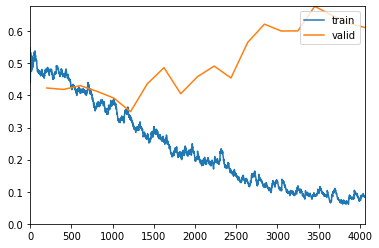

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.932113,0.590626,0.260000,0.740000,0.726389,00:22
1,0.644907,0.474928,0.173333,0.826667,0.739444,00:22
2,0.529972,0.441832,0.206667,0.793333,0.776944,00:22
3,0.475807,0.409483,0.226667,0.773333,0.788333,00:22


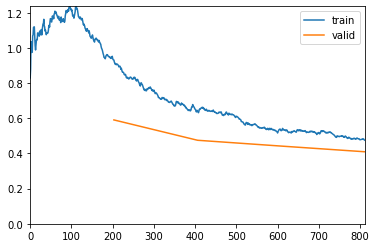

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.475255,0.389769,0.180000,0.820000,0.804722,00:30
1,0.472482,0.402128,0.140000,0.860000,0.786945,00:30
2,0.415817,0.410424,0.133333,0.866667,0.800000,00:30
3,0.387732,0.405191,0.166667,0.833333,0.820556,00:30
4,0.378496,0.387967,0.153333,0.846667,0.848056,00:30
5,0.336096,0.379624,0.140000,0.860000,0.873333,00:30
6,0.245631,0.432671,0.140000,0.860000,0.867778,00:30
7,0.250635,0.462045,0.166667,0.833333,0.870278,00:30
8,0.224060,0.363115,0.120000,0.880000,0.891111,00:30
9,0.196091,0.435192,0.140000,0.860000,0.869167,00:30


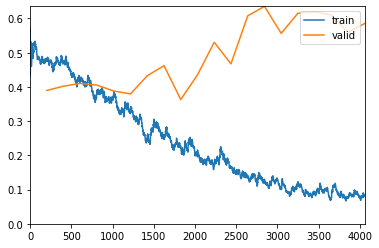

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.871845,0.690989,0.240000,0.760000,0.729583,00:16
1,0.637343,0.412640,0.160000,0.840000,0.790278,00:16
2,0.541541,0.442384,0.166667,0.833333,0.769444,00:16
3,0.513932,0.416976,0.153333,0.846667,0.781667,00:16


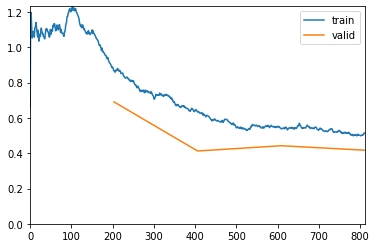

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.463968,0.402875,0.180000,0.820000,0.800000,00:23
1,0.470992,0.397982,0.160000,0.840000,0.793889,00:23
2,0.417854,0.411014,0.146667,0.853333,0.811389,00:23
3,0.373923,0.423689,0.166667,0.833333,0.798611,00:23
4,0.369415,0.399816,0.146667,0.853333,0.831389,00:23
5,0.338084,0.414486,0.166667,0.833333,0.853889,00:23
6,0.302577,0.433670,0.140000,0.860000,0.870000,00:23
7,0.252626,0.388106,0.160000,0.840000,0.861389,00:23
8,0.225468,0.534388,0.166667,0.833333,0.820555,00:23
9,0.207877,0.421628,0.153333,0.846667,0.866389,00:23


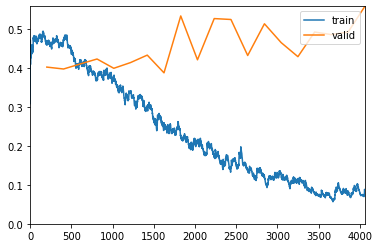

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.880290,0.705733,0.233333,0.766667,0.724445,00:22
1,0.637168,0.422416,0.180000,0.820000,0.783611,00:22
2,0.548229,0.439893,0.166667,0.833333,0.772500,00:22
3,0.501283,0.420971,0.160000,0.840000,0.778889,00:22


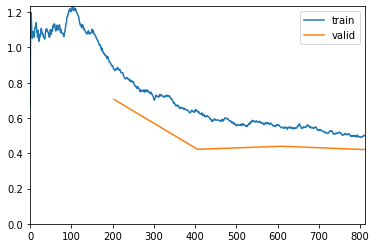

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.462394,0.402786,0.153333,0.846667,0.799444,00:30
1,0.468532,0.388122,0.153333,0.846667,0.811944,00:30
2,0.412303,0.405411,0.146667,0.853333,0.811111,00:30
3,0.370990,0.466433,0.166667,0.833333,0.765833,00:30
4,0.370356,0.399915,0.166667,0.833333,0.853611,00:30
5,0.344149,0.411832,0.160000,0.840000,0.862222,00:30
6,0.295598,0.422925,0.133333,0.866667,0.865278,00:30
7,0.249727,0.405949,0.186667,0.813333,0.850278,00:30
8,0.234291,0.475617,0.186667,0.813333,0.847778,00:30
9,0.190095,0.407023,0.160000,0.840000,0.872500,00:30


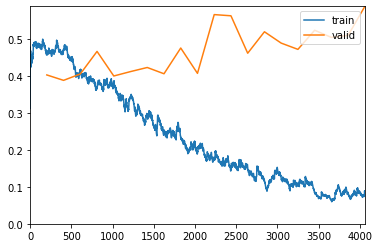

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.942050,0.532974,0.206667,0.793333,0.755278,00:16
1,0.642904,0.477077,0.193333,0.806667,0.729167,00:16
2,0.558963,0.411413,0.160000,0.840000,0.789167,00:16
3,0.486971,0.402696,0.140000,0.860000,0.778889,00:16


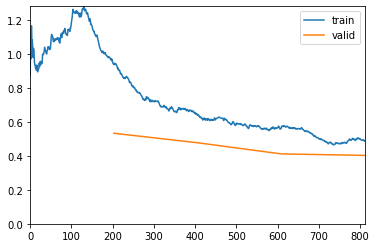

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.499921,0.406564,0.140000,0.860000,0.778333,00:23
1,0.477819,0.415310,0.133333,0.866667,0.778333,00:23
2,0.435493,0.409302,0.140000,0.860000,0.807500,00:23
3,0.393527,0.384645,0.180000,0.820000,0.836945,00:23
4,0.361778,0.434387,0.140000,0.860000,0.836944,00:23
5,0.337441,0.506151,0.186667,0.813333,0.821944,00:23
6,0.310085,0.419156,0.153333,0.846667,0.830555,00:23
7,0.258751,0.531845,0.160000,0.840000,0.836667,00:23
8,0.248432,0.414717,0.160000,0.840000,0.868056,00:23
9,0.180297,0.568233,0.180000,0.820000,0.821111,00:23


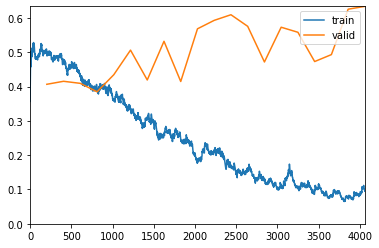

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.945337,0.522345,0.173333,0.826667,0.767778,00:22
1,0.647175,0.481297,0.200000,0.800000,0.726389,00:22
2,0.555395,0.395943,0.173333,0.826667,0.798889,00:22
3,0.476731,0.398445,0.140000,0.860000,0.785556,00:22


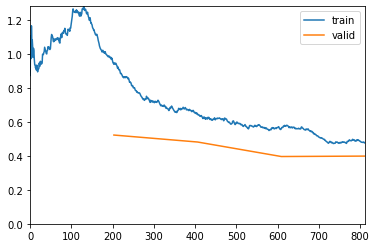

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.498369,0.399040,0.140000,0.860000,0.784167,00:30
1,0.479185,0.407047,0.133333,0.866667,0.776945,00:30
2,0.424850,0.376390,0.160000,0.840000,0.833056,00:30
3,0.387546,0.371117,0.166667,0.833333,0.847500,00:30
4,0.349365,0.407783,0.173333,0.826667,0.836667,00:30
5,0.320444,0.443857,0.153333,0.846667,0.857778,00:30
6,0.305958,0.338610,0.133333,0.866667,0.897778,00:30
7,0.269980,0.327478,0.133333,0.866667,0.896944,00:30
8,0.233810,0.351170,0.140000,0.860000,0.883889,00:30
9,0.165125,0.523568,0.166667,0.833333,0.858889,00:30


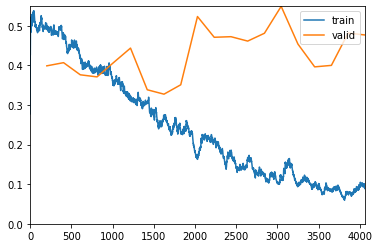

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.925277,0.574381,0.233333,0.766667,0.759722,00:16
1,0.644683,0.454716,0.206667,0.793333,0.783333,00:16
2,0.536341,0.399639,0.160000,0.840000,0.816389,00:16
3,0.464936,0.412181,0.160000,0.840000,0.775833,00:16


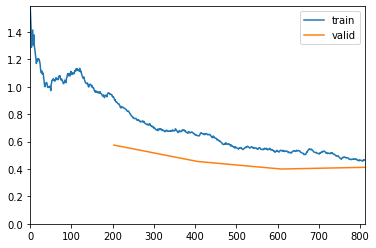

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.484509,0.399960,0.140000,0.860000,0.785556,00:23
1,0.480525,0.374240,0.173333,0.826667,0.826667,00:23
2,0.411855,0.366994,0.140000,0.860000,0.853056,00:23
3,0.364660,0.369874,0.126667,0.873333,0.864722,00:23
4,0.346944,0.400145,0.140000,0.860000,0.859722,00:23
5,0.340273,0.473312,0.140000,0.860000,0.824167,00:23
6,0.259845,0.452562,0.166667,0.833333,0.850556,00:23
7,0.258840,0.468515,0.146667,0.853333,0.856667,00:23
8,0.209627,0.575170,0.166667,0.833333,0.855278,00:23
9,0.158415,0.571057,0.153333,0.846667,0.863889,00:23


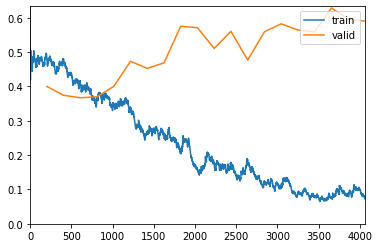

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.919356,0.599278,0.253333,0.746667,0.751944,00:22
1,0.654161,0.466136,0.186667,0.813333,0.753611,00:22
2,0.516783,0.416610,0.166667,0.833333,0.801667,00:22
3,0.457161,0.420435,0.160000,0.840000,0.763333,00:22


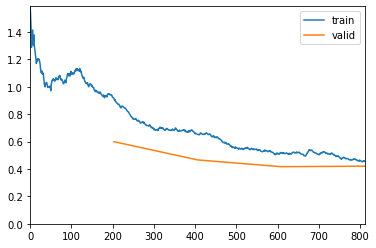

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.471945,0.413193,0.140000,0.860000,0.768056,00:30
1,0.473317,0.384202,0.153333,0.846667,0.815556,00:30
2,0.412776,0.373712,0.160000,0.840000,0.854444,00:30
3,0.364789,0.407492,0.133333,0.866667,0.842778,00:30
4,0.351740,0.364148,0.120000,0.880000,0.868889,00:30
5,0.336672,0.439634,0.166667,0.833333,0.818056,00:30
6,0.265323,0.448755,0.180000,0.820000,0.841667,00:30
7,0.253452,0.402743,0.140000,0.860000,0.869167,00:30
8,0.223059,0.575107,0.153333,0.846667,0.858056,00:30
9,0.170974,0.510969,0.153333,0.846667,0.835278,00:30


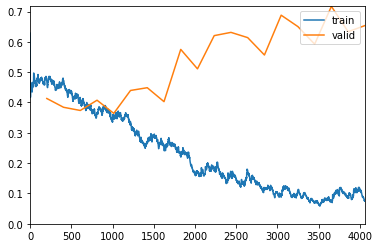

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.962489,0.534519,0.193333,0.806667,0.705000,00:16
1,0.631428,0.437406,0.200000,0.800000,0.799444,00:16
2,0.545603,0.435814,0.193333,0.806667,0.776389,00:16
3,0.486662,0.410101,0.166667,0.833333,0.788611,00:16


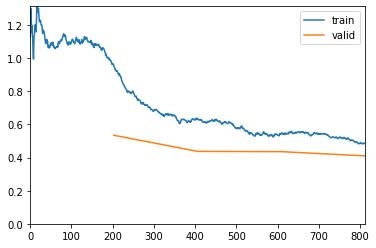

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.468265,0.404290,0.153333,0.846667,0.800278,00:23
1,0.454807,0.383206,0.160000,0.840000,0.827222,00:23
2,0.448472,0.414198,0.166667,0.833333,0.792500,00:23
3,0.394351,0.453981,0.173333,0.826667,0.808056,00:23
4,0.306457,0.417543,0.166667,0.833333,0.835278,00:23
5,0.337986,0.514557,0.166667,0.833333,0.784167,00:23
6,0.286348,0.423982,0.153333,0.846667,0.829722,00:23
7,0.280504,0.465407,0.193333,0.806667,0.798889,00:23
8,0.225964,0.642961,0.173333,0.826667,0.833611,00:23
9,0.220087,0.504468,0.193333,0.806667,0.809444,00:23


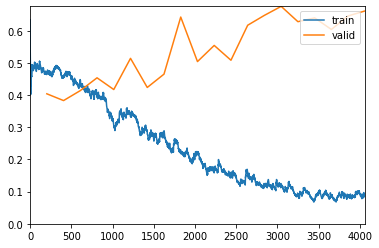

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.962398,0.525197,0.186667,0.813333,0.715555,00:22
1,0.631277,0.415861,0.193333,0.806667,0.808611,00:22
2,0.541185,0.439562,0.166667,0.833333,0.783611,00:22
3,0.484142,0.414909,0.153333,0.846667,0.778055,00:22


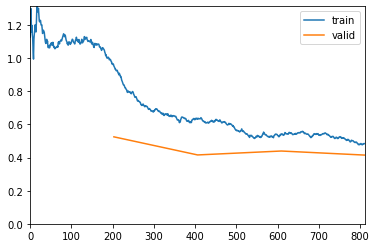

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.469835,0.406163,0.146667,0.853333,0.783611,00:30
1,0.453247,0.388751,0.153333,0.846667,0.817500,00:30
2,0.431843,0.406241,0.160000,0.840000,0.803333,00:30
3,0.400219,0.472725,0.173333,0.826667,0.783333,00:30
4,0.320789,0.431476,0.166667,0.833333,0.834167,00:30
5,0.334502,0.431119,0.160000,0.840000,0.816667,00:30
6,0.277123,0.449173,0.140000,0.860000,0.788889,00:30
7,0.292677,0.424710,0.160000,0.840000,0.813611,00:30
8,0.233543,0.562444,0.193333,0.806667,0.824444,00:30
9,0.239771,0.452516,0.166667,0.833333,0.814167,00:30


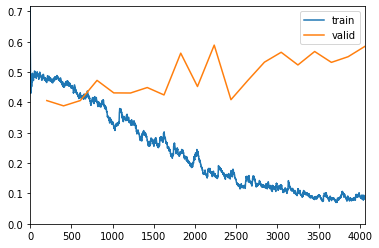

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.875056,0.799622,0.286667,0.713333,0.687500,00:16
1,0.650468,0.437232,0.186667,0.813333,0.767778,00:16
2,0.572944,0.405639,0.180000,0.820000,0.804167,00:16
3,0.490470,0.425814,0.173333,0.826667,0.785834,00:16


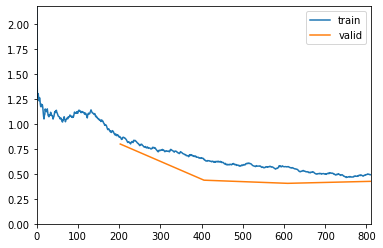

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.499241,0.410805,0.153333,0.846667,0.799444,00:23
1,0.434052,0.377897,0.146667,0.853333,0.825833,00:23
2,0.396881,0.380025,0.166667,0.833333,0.841667,00:23
3,0.384481,0.399470,0.180000,0.820000,0.835278,00:23
4,0.341130,0.396289,0.133333,0.866667,0.855000,00:23
5,0.309297,0.474604,0.193333,0.806667,0.803611,00:23
6,0.308763,0.385312,0.166667,0.833333,0.846667,00:23
7,0.263342,0.417700,0.126667,0.873333,0.849444,00:23
8,0.238975,0.472682,0.153333,0.846667,0.845833,00:23
9,0.195575,0.468490,0.153333,0.846667,0.845000,00:23


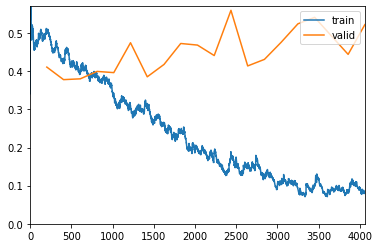

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.874974,0.853395,0.306667,0.693333,0.671389,00:22
1,0.644393,0.468929,0.173333,0.826667,0.750000,00:22
2,0.564867,0.412607,0.193333,0.806667,0.799444,00:22
3,0.501437,0.429850,0.180000,0.820000,0.786389,00:22


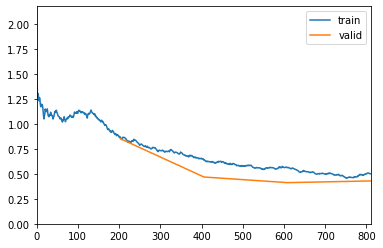

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.497537,0.415068,0.160000,0.840000,0.798611,00:30
1,0.443051,0.380597,0.140000,0.860000,0.831667,00:30
2,0.403095,0.391707,0.153333,0.846667,0.829722,00:30
3,0.383845,0.383133,0.166667,0.833333,0.846667,00:30
4,0.344124,0.337654,0.120000,0.880000,0.892500,00:30
5,0.324909,0.437451,0.173333,0.826667,0.826944,00:30
6,0.305681,0.436650,0.160000,0.840000,0.838333,00:30
7,0.243120,0.423713,0.160000,0.840000,0.849167,00:30
8,0.231494,0.469666,0.146667,0.853333,0.826667,00:30
9,0.201869,0.504924,0.140000,0.860000,0.844167,00:30


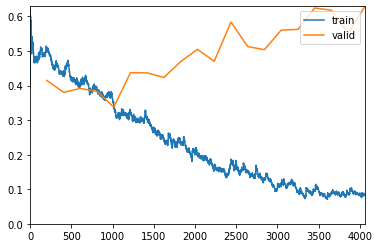

In [14]:
seeds = range(1,11)
epochs = 20

for seed in seeds:
    #Baseline
    data = reload_dataset(dm,seed=seed)    
    baseline_acc, baseline_auroc = train_model_and_return_metrics(data,models.resnet50, seed,epochs)
    
    #ARL
    data = reload_dataset(dm,seed=seed)
    
    ResNet50_with_attn = models.resnet50(pretrained=True)
    apply_leaf(ResNet50_with_attn, change_basic_blocks)
    
    arl_acc, arl_auroc = train_model_and_return_metrics(data,lambda x: ResNet50_with_attn, seed,epochs)


    
    write_results(seed, baseline_acc, baseline_auroc, arl_acc,arl_auroc)
    